In [1]:
#import numpy as np
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from collections import Counter
import os
import zipfile
import shutil
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
import random


2024-11-20 12:46:07.494935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732124767.898753  834909 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732124768.047032  834909 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 12:46:08.931678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def process_images_with_tf(image_paths, labels, images_mmap_path, labels_mmap_path, batch_size=500):
    total_images = len(image_paths)
    print(f"\nProcessing {total_images} images for memory-mapped storage...")

    # Define image shape and dtype for memory-mapped storage
    image_shape = (256, 256, 3)
    dtype = 'float32'

    # Create memory-mapped arrays for images and labels
    images_mmap = np.memmap(images_mmap_path, dtype=dtype, mode='w+', shape=(total_images, *image_shape))
    labels_mmap = np.memmap(labels_mmap_path, dtype='int32', mode='w+', shape=(total_images,))

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def _load_and_preprocess_image(file_path, label):
        try:
            img = tf.io.read_file(file_path)
            img = tf.io.decode_image(img, channels=3, expand_animations=False)
            img.set_shape([None, None, 3])
            img = tf.image.resize(img, [256, 256])
            img = tf.cast(img, tf.float32) / 255.0
            return img, label
        except Exception as e:
            tf.print(f"Error processing image {file_path}: {e}")
            img = tf.zeros([256, 256, 3], dtype=tf.float32)
            return img, label

    dataset = dataset.map(_load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    idx = 0
    for batch_imgs, batch_labels in tqdm(dataset, total=(total_images // batch_size) + 1, desc="Processing Images"):
        batch_imgs_np = batch_imgs.numpy()
        batch_labels_np = batch_labels.numpy()
        batch_size_actual = batch_imgs_np.shape[0]
        images_mmap[idx:idx+batch_size_actual] = batch_imgs_np
        labels_mmap[idx:idx+batch_size_actual] = batch_labels_np
        idx += batch_size_actual

        # Flush changes to memory-mapped file to disk and clear memory
        images_mmap.flush()
        labels_mmap.flush()
        gc.collect()

    del images_mmap
    del labels_mmap
    print(f"Finished processing {total_images} images into {images_mmap_path} and {labels_mmap_path}.")


In [ ]:

# --------------------- Configuration ---------------------

# Configure logging to capture errors during processing
logging.basicConfig(
    filename='data_processing.log',
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Define paths for memory-mapped arrays
IMAGES_D_MEMMAP_PATH = 'images_d_mmap.npy'
LABELS_D_MEMMAP_PATH = 'labels_d.npy'
IMAGES_P_MEMMAP_PATH = 'images_p_mmap.npy'
LABELS_P_MEMMAP_PATH = 'labels_p.npy'

# Temporary extraction directory
TEMP_DIR = "temp_extracted"

# Sampling fraction (50%)
SAMPLE_FRACTION = .5

# Seed for reproducibility
RANDOM_SEED = 42

# --------------------- Setup ---------------------

# Ensure temporary directory exists
os.makedirs(TEMP_DIR, exist_ok=True)

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Enable GPU processing for TensorFlow, if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) detected and memory growth enabled.")
    except RuntimeError as e:
        print(e)

# --------------------- Helper Functions ---------------------

def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    
    Parameters:
    - filename (str): Name of the file.
    
    Returns:
    - bool: True if the file is an image, False otherwise.
    """
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def extract_images_and_labels(zip_path, image_filenames, temp_dir, label):
    """
    Extract images from a zip file to a temporary directory and assign labels.
    
    Parameters:
    - zip_path (str): Path to the zip file.
    - image_filenames (list): List of image file paths within the zip.
    - temp_dir (str): Directory to extract images to.
    - label (int): Label to assign to all extracted images.
    
    Returns:
    - extracted_paths (list): List of paths to the extracted images.
    - labels (list): List of labels corresponding to the extracted images.
    """
    extracted_paths = []
    labels = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_path in tqdm(image_filenames, desc=f"Extracting to {temp_dir}"):
            try:
                zip_ref.extract(img_path, temp_dir)
                extracted_file_path = os.path.join(temp_dir, img_path)
                extracted_paths.append(extracted_file_path)
                labels.append(label)  # Assign the passed label
            except Exception as e:
                logging.error(f"Error extracting {img_path}: {e}")
                continue
    return extracted_paths, labels

# --------------------- Main Processing Function ---------------------

def main():
    """
    Main function to process images from 'D' and 'P' folders within 'SDNET2018.zip'.
    It samples 20% of images from each subfolder, assigns labels, processes images,
    and saves them into separate memory-mapped files.
    """
    zip_path = 'SDNET2018.zip'  # Path to your zip file
    batch_size = 500  # Adjust based on available memory

    # Define mapping from subfolders to labels
    subfolder_label_mapping = {
        'SDNET2018/D/UD': 0,  # Uncracked
        'SDNET2018/D/CD': 1,  # Cracked
        'SDNET2018/P/UP': 0,  # Uncracked
        'SDNET2018/P/CP': 1   # Cracked
    }

    # Extract all filenames from the zip file
    print(f"Opening zip file: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_filenames = zip_ref.namelist()

    # Function to filter image filenames from a specific subfolder
    def get_image_filenames(subfolder):
        prefix = subfolder + '/'
        return [f for f in all_filenames if f.startswith(prefix) and is_image_file(f)]

    # Initialize dictionaries to hold image paths and labels for D and P
    data = {
        'D': {'image_paths': [], 'labels': []},
        'P': {'image_paths': [], 'labels': []}
    }

    # Iterate over each subfolder and process images
    for subfolder, label in subfolder_label_mapping.items():
        image_filenames = get_image_filenames(subfolder)
        total_images = len(image_filenames)
        sample_size = max(1, int(total_images * SAMPLE_FRACTION))  # Ensure at least 1 image is sampled

        # Randomly sample 20% of the images
        sampled_filenames = random.sample(image_filenames, sample_size)

        print(f"\nFound {total_images} images in subfolder '{subfolder}'. Sampling {sample_size} images for label {label}.")

        # Extract images and assign labels
        image_paths, labels = extract_images_and_labels(zip_path, sampled_filenames, TEMP_DIR, label)

        # Determine main folder (D or P) based on subfolder
        main_folder = subfolder.split('/')[1]

        # Append to the respective main folder's data
        data[main_folder]['image_paths'].extend(image_paths)
        data[main_folder]['labels'].extend(labels)

    # Process and save D folder data
    if data['D']['image_paths']:
        process_images_with_tf(
            data['D']['image_paths'],
            labels=data['D']['labels'],
            images_mmap_path=IMAGES_D_MEMMAP_PATH,
            labels_mmap_path=LABELS_D_MEMMAP_PATH,
            batch_size=batch_size
        )

        # Save the filenames and labels for D
        np.save('filenames_d.npy', data['D']['image_paths'])
        np.save('labels_d.npy', data['D']['labels'])
    else:
        print("\nNo images found for 'D' folder after sampling.")

    # Process and save P folder data
    if data['P']['image_paths']:
        process_images_with_tf(
            data['P']['image_paths'],
            labels=data['P']['labels'],
            images_mmap_path=IMAGES_P_MEMMAP_PATH,
            labels_mmap_path=LABELS_P_MEMMAP_PATH,
            batch_size=batch_size
        )

        # Save the filenames and labels for P
        np.save('filenames_p.npy', data['P']['image_paths'])
        np.save('labels_p.npy', data['P']['labels'])
    else:
        print("\nNo images found for 'P' folder after sampling.")

    # Clear temporary directory
    shutil.rmtree(TEMP_DIR)
    os.makedirs(TEMP_DIR, exist_ok=True)

    # Free up memory
    del data
    gc.collect()

    print("\nFilenames and labels saved for 'D' and 'P' folders.")

# --------------------- Execute Script ---------------------

if __name__ == "__main__":
    main()


In [19]:
from sklearn.model_selection import train_test_split
# Paths for memory-mapped files after processing images
IMAGES_D_MEMMAP_PATH = 'images_d_mmap.npy'
LABELS_D_MEMMAP_PATH = 'labels_d.npy'
IMAGES_P_MEMMAP_PATH = 'images_p_mmap.npy'
LABELS_P_MEMMAP_PATH = 'labels_p.npy'

# Ensure that necessary files exist
if not (os.path.exists(IMAGES_D_MEMMAP_PATH) and os.path.exists(LABELS_D_MEMMAP_PATH) and os.path.exists(IMAGES_P_MEMMAP_PATH) and os.path.exists(LABELS_P_MEMMAP_PATH)):
    print("Required processed files not found. Make sure to run the image extraction and processing first.")
    exit()

# Load labels for datasets D and P
labels_d = np.load(LABELS_D_MEMMAP_PATH)
labels_p = np.load(LABELS_P_MEMMAP_PATH)

# Define the number of images in each set
total_images_d = len(labels_d)
total_images_p = len(labels_p)

# Load images from memory-mapped files
images_d = np.memmap(
    IMAGES_D_MEMMAP_PATH,
    dtype='float32',
    mode='r',
    shape=(total_images_d, 256, 256, 3)
)

images_p = np.memmap(
    IMAGES_P_MEMMAP_PATH,
    dtype='float32',
    mode='r',
    shape=(total_images_p, 256, 256, 3)
)

# Verify that the number of labels matches the number of images
assert len(labels_d) == total_images_d, "Mismatch in number of D labels and images."
assert len(labels_p) == total_images_p, "Mismatch in number of P labels and images."

print("Data loaded successfully.")

# Split the D data into training and test sets (80% training, 20% testing)
train_indices_d, test_indices_d = train_test_split(
    np.arange(total_images_d),
    test_size=0.20,
    random_state=42,
    stratify=labels_d
)

# Extract training and testing images and labels for D
train_images_d = images_d[train_indices_d]
train_labels_d = labels_d[train_indices_d]
test_images_d = images_d[test_indices_d]
test_labels_d = labels_d[test_indices_d]

print(f"Train Set D: {len(train_images_d)} samples.")
print(f"Test Set D: {len(test_images_d)} samples.")

# Split the P data into training and test sets (80% training, 20% testing)
train_indices_p, test_indices_p = train_test_split(
    np.arange(total_images_p),
    test_size=0.20,
    random_state=42,
    stratify=labels_p
)

# Extract training and testing images and labels for P
train_images_p = images_p[train_indices_p]
train_labels_p = labels_p[train_indices_p]
test_images_p = images_p[test_indices_p]
test_labels_p = labels_p[test_indices_p]

print(f"Train Set P: {len(train_images_p)} samples.")
print(f"Test Set P: {len(test_images_p)} samples.")

# Combine D and P training data for Train Set A (large and diverse)
train_images_A = np.concatenate((train_images_d, train_images_p), axis=0)
train_labels_A = np.concatenate((train_labels_d, train_labels_p), axis=0)

print(f"Train Set A (Large and Diverse): {len(train_images_A)} samples.")

# Create a small, diverse training set by taking 10% of Train Set A (Train Set B)
fraction_B = 0.10  # 10%
num_samples_B = int(len(train_images_A) * fraction_B)

# Randomly sample Train Set B from Train Set A
indices_B = np.random.choice(len(train_images_A), size=num_samples_B, replace=False)
train_images_B = train_images_A[indices_B]
train_labels_B = train_labels_A[indices_B]

print(f"Train Set B (Small and Diverse): {len(train_images_B)} samples.")

# Define Train Set C as all D training data
train_images_C = train_images_d
train_labels_C = train_labels_d

print(f"Train Set C (D only): {len(train_images_C)} samples.")

# Define Test Set D (only D testing data)
test_images_D = test_images_d
test_labels_D = test_labels_d

print(f"Test Set D (D only): {len(test_images_D)} samples.")

# Define Test Set P (only P testing data)
test_images_P = test_images_p
test_labels_P = test_labels_p

print(f"Test Set P (P only): {len(test_images_P)} samples.")

# Function to save datasets
def save_dataset(images, labels, images_path, labels_path):
    np.save(images_path, images)
    np.save(labels_path, labels)

# Save Train Set A
save_dataset(train_images_A, train_labels_A, 'train_set_A_images.npy', 'train_set_A_labels.npy')

# Save Train Set B
save_dataset(train_images_B, train_labels_B, 'train_set_B_images.npy', 'train_set_B_labels.npy')

# Save Train Set C
save_dataset(train_images_C, train_labels_C, 'train_set_C_images.npy', 'train_set_C_labels.npy')

# Save Test Set D
save_dataset(test_images_D, test_labels_D, 'test_set_D_images.npy', 'test_set_D_labels.npy')

# Save Test Set P
save_dataset(test_images_P, test_labels_P, 'test_set_P_images.npy', 'test_set_P_labels.npy')

print("\nAll datasets have been saved successfully.")

Data loaded successfully.
Train Set D: 5141 samples.
Test Set D: 1286 samples.
Train Set P: 9733 samples.
Test Set P: 2434 samples.
Train Set A (Large and Diverse): 14874 samples.
Train Set B (Small and Diverse): 1487 samples.
Train Set C (D only): 5141 samples.
Test Set D (D only): 1286 samples.
Test Set P (P only): 2434 samples.

All datasets have been saved successfully.


In [2]:


# Load the datasets
train_images_A = np.load('train_set_A_images.npy')
train_labels_A = np.load('train_set_A_labels.npy')

train_images_B = np.load('train_set_B_images.npy')
train_labels_B = np.load('train_set_B_labels.npy')

train_images_C = np.load('train_set_C_images.npy')
train_labels_C = np.load('train_set_C_labels.npy')

test_images_D = np.load('test_set_D_images.npy')
test_labels_D = np.load('test_set_D_labels.npy')

test_images_P = np.load('test_set_P_images.npy')
test_labels_P = np.load('test_set_P_labels.npy')


In [3]:

# Define function to print class distributions
def print_class_distribution(labels, set_name):
    class_counts = Counter(labels)
    print(f"Class distribution for {set_name}: {dict(class_counts)}")

# Print class distributions for each training and test set
print_class_distribution(train_labels_A, "Train Set A (Large and Diverse)")
print_class_distribution(train_labels_B, "Train Set B (Small and Diverse)")
print_class_distribution(train_labels_C, "Train Set C (D only)")

print_class_distribution(test_labels_D, "Test Set D (D only)")
print_class_distribution(test_labels_P, "Test Set P (P only)")


Class distribution for Train Set A (Large and Diverse): {0: 13327, 1: 1547}
Class distribution for Train Set B (Small and Diverse): {0: 1338, 1: 149}
Class distribution for Train Set C (D only): {0: 4637, 1: 504}
Class distribution for Test Set D (D only): {0: 1160, 1: 126}
Class distribution for Test Set P (P only): {0: 2173, 1: 261}


In [3]:
from sklearn.utils.class_weight import compute_class_weight


In [4]:
def get_class_weights(labels):
    class_count = Counter(labels)
    total = sum(class_count.values())
    class_weights = {label: total / (len(class_count) * count) for label, count in class_count.items()}
    return class_weights


In [5]:
# Data Augmentation Pipeline using Keras Layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Updated Data Generator Function
def create_data_generator(images, labels, batch_size=16, shuffle=True, augment=True):
    images = images.astype('float32')
    labels = labels.astype('int64')

    def generator():
        indices = np.arange(len(images))
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_indices = indices[start:end]
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]
            
            if augment:
                batch_images = data_augmentation(batch_images)
            
            yield tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    output_signature = (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int64)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

# Create Generators for Training and Testing
train_gen_A = create_data_generator(train_images_A, train_labels_A, batch_size=16, shuffle=True, augment=True)
train_gen_B = create_data_generator(train_images_B, train_labels_B, batch_size=16, shuffle=True, augment=True)
train_gen_C = create_data_generator(train_images_C, train_labels_C, batch_size=16, shuffle=True, augment=True)
# For the test generator, set shuffle=False and augment=False
test_gen_D = create_data_generator(test_images_D, test_labels_D, batch_size=16, shuffle=False, augment=False)
test_gen_P= create_data_generator(test_images_P, test_labels_P, batch_size=16, shuffle=False, augment=False)
# Calculate the number of steps for the test generator
num_test_samples = len(test_images_D)
test_steps = np.ceil(num_test_samples / 16).astype(int)

I0000 00:00:1732124808.920801  834909 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46853 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6
I0000 00:00:1732124808.921744  834909 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46853 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6
I0000 00:00:1732124808.922435  834909 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46853 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [6]:


class_weights = get_class_weights(train_labels_A)
class_weights
adjustment_factor = 0.5  # Adjust this factor between 0 and 1
class_weights[1] = class_weights[1] * adjustment_factor
print("Adjusted class weights:", class_weights)

Adjusted class weights: {0: 0.5580400690327906, 1: 2.403684550743374}


In [7]:
# For training sets
num_train_samples_A = len(train_labels_A)
num_train_samples_B = len(train_labels_B)
num_train_samples_C = len(train_labels_C)

# For test sets
num_test_samples_D = len(test_labels_D)
num_test_samples_P = len(test_labels_P)


batch_size=16

steps_per_epoch_A = np.ceil(num_train_samples_A / batch_size).astype(int)
steps_per_epoch_B = np.ceil(num_train_samples_B / batch_size).astype(int)
steps_per_epoch_C = np.ceil(num_train_samples_C / batch_size).astype(int)

validation_steps_D = np.ceil(num_test_samples_D / batch_size).astype(int)
validation_steps_P = np.ceil(num_test_samples_P / batch_size).astype(int)


In [8]:
from tensorflow.keras import backend as K

def focal_loss(alpha=1, gamma=0):
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross-entropy loss
        ce_loss = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

        # Compute the focal loss scaling factor
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_factor = K.pow(1 - p_t, gamma)

        # Compute the focal loss
        focal_loss = alpha * focal_factor * ce_loss

        # Return the mean loss over the batch
        return K.mean(focal_loss)
    focal_loss_fixed.__name__ = 'focal_loss_fixed'  # Important to set the name
    return focal_loss_fixed

In [12]:
from tensorflow.keras.applications import ResNet50


In [16]:
def train_and_evaluate(
    train_gen,
    test_gen,
    train_labels,
    test_labels,
    set_name,
    batch_size=16,
    alpha=1,
    gamma=0
):
    # Load VGG16 pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False

    # Build transfer learning model
    model_transfer = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the Model with Custom Focal Loss
    model_transfer.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=['accuracy']
    )

    # Define Callbacks
    callbacks_transfer = [
        tf.keras.callbacks.ModelCheckpoint(
            f'best_model_transfer_{set_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]

    # Train the Model
    history_transfer = model_transfer.fit(
        train_gen,
        validation_data=test_gen,
        epochs=1,  # Adjust as needed
        callbacks=callbacks_transfer,
        verbose=1
    )

    # Unfreeze Layers for Fine-tuning
    base_model.trainable = True

    # Recompile the Model
    model_transfer.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=['accuracy']
    )

    # Fine-tune the Model
    history_fine_tune = model_transfer.fit(
        train_gen,
        validation_data=test_gen,
        epochs=5,  # Adjust as needed
        callbacks=callbacks_transfer,
        verbose=1
    )

    # Load the Best Model
    best_model = tf.keras.models.load_model(
        f'best_model_transfer_{set_name}.keras',
        custom_objects={'focal_loss_fixed': focal_loss(alpha=alpha, gamma=gamma)}
    )

    # Evaluate on test set
    num_test_samples = len(test_labels)
    validation_steps = np.ceil(num_test_samples / batch_size).astype(int)

    predictions = best_model.predict(test_gen, steps=validation_steps)
    predicted_labels = (predictions >= 0.15).astype(int).flatten()

    # Compute and print confusion matrix and metrics
    cm = confusion_matrix(test_labels[:len(predicted_labels)], predicted_labels)
    precision = precision_score(test_labels[:len(predicted_labels)], predicted_labels, zero_division=0)
    recall = recall_score(test_labels[:len(predicted_labels)], predicted_labels, zero_division=0)
    report = classification_report(
        test_labels[:len(predicted_labels)],
        predicted_labels,
        target_names=['Uncracked', 'Cracked'],
        zero_division=0
    )

    print(f"Confusion Matrix (Test Set {set_name}):")
    print(cm)
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Uncracked (0)', 'Cracked (1)'],
        yticklabels=['Uncracked (0)', 'Cracked (1)']
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix (Test Set {set_name})')
    plt.show()


In [17]:
# List of training generators and labels with their set names
training_sets = [
    {'name': 'A', 'gen': train_gen_A, 'labels': train_labels_A},
    {'name': 'B', 'gen': train_gen_B, 'labels': train_labels_B},
    {'name': 'C', 'gen': train_gen_C, 'labels': train_labels_C},
    # Add more training sets if available
]

# List of testing generators and labels with their set names
testing_sets = [
    {'name': 'D', 'gen': test_gen_D, 'labels': test_labels_D},
    {'name': 'P', 'gen': test_gen_P, 'labels': test_labels_P},
    # Add more testing sets if available
]


Training on set A and testing on set D
    930/Unknown 49s 48ms/step - accuracy: 0.8908 - loss: 0.4972

2024-11-20 13:09:51.427037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-20 13:09:51.427173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to best_model_transfer_A_to_D.keras


2024-11-20 13:09:55.695876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:09:55.695993: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 54s 53ms/step - accuracy: 0.8908 - loss: 0.4970 - val_accuracy: 0.9020 - val_loss: 0.2483 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
    930/Unknown 115s 109ms/step - accuracy: 0.9008 - loss: 0.2803

2024-11-20 13:11:50.626763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 1: val_accuracy improved from 0.90202 to 0.96190, saving model to best_model_transfer_A_to_D.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 118s 113ms/step - accuracy: 0.9008 - loss: 0.2802 - val_accuracy: 0.9619 - val_loss: 0.1213 - learning_rate: 1.0000e-05
Epoch 2/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9402 - loss: 0.1961
Epoch 2: val_accuracy improved from 0.96190 to 0.96656, saving model to best_model_transfer_A_to_D.keras


2024-11-20 13:13:30.835590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:13:30.835694: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9402 - loss: 0.1961 - val_accuracy: 0.9666 - val_loss: 0.1051 - learning_rate: 1.0000e-05
Epoch 3/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9435 - loss: 0.1887

2024-11-20 13:15:05.870742: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 3: val_accuracy did not improve from 0.96656
930/930 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9435 - loss: 0.1887 - val_accuracy: 0.9580 - val_loss: 0.1147 - learning_rate: 1.0000e-05
Epoch 4/5
  1/930 ━━━━━━━━━━━━━━━━━━━━ 2:07 137ms/step - accuracy: 0.9375 - loss: 0.2043

2024-11-20 13:15:07.927483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:15:07.927607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9457 - loss: 0.1858
Epoch 4: val_accuracy improved from 0.96656 to 0.97512, saving model to best_model_transfer_A_to_D.keras


2024-11-20 13:16:44.254765: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9457 - loss: 0.1857 - val_accuracy: 0.9751 - val_loss: 0.0773 - learning_rate: 1.0000e-05
Epoch 5/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9527 - loss: 0.1662

2024-11-20 13:18:19.780599: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:18:19.780748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 5: val_accuracy did not improve from 0.97512
930/930 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9527 - loss: 0.1662 - val_accuracy: 0.9697 - val_loss: 0.0866 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 4.
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Confusion Matrix (Test Set A_to_D):
[[1120   40]
 [  11  115]]

Precision: 0.7419
Recall:    0.9127

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.99      0.97      0.98      1160
     Cracked       0.74      0.91      0.82       126

    accuracy                           0.96      1286
   macro avg       0.87      0.94      0.90      1286
weighted avg       0.97      0.96      0.96      1286



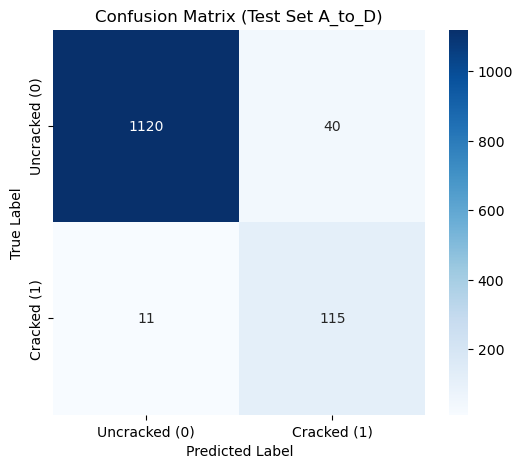


Training on set A and testing on set P
    930/Unknown 48s 49ms/step - accuracy: 0.8901 - loss: 0.3889

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.89277, saving model to best_model_transfer_A_to_P.keras


2024-11-20 13:19:19.985448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 54s 55ms/step - accuracy: 0.8901 - loss: 0.3888 - val_accuracy: 0.8928 - val_loss: 0.3085 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
    930/Unknown 104s 104ms/step - accuracy: 0.9114 - loss: 0.2605
Epoch 1: val_accuracy improved from 0.89277 to 0.94536, saving model to best_model_transfer_A_to_P.keras


2024-11-20 13:21:09.017825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 109s 110ms/step - accuracy: 0.9115 - loss: 0.2605 - val_accuracy: 0.9454 - val_loss: 0.1621 - learning_rate: 1.0000e-05
Epoch 2/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9386 - loss: 0.2015
Epoch 2: val_accuracy improved from 0.94536 to 0.94659, saving model to best_model_transfer_A_to_P.keras


2024-11-20 13:22:47.353221: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:22:47.353335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 98s 106ms/step - accuracy: 0.9386 - loss: 0.2015 - val_accuracy: 0.9466 - val_loss: 0.1575 - learning_rate: 1.0000e-05
Epoch 3/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9512 - loss: 0.1729

2024-11-20 13:24:22.750126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:24:22.750278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 3: val_accuracy did not improve from 0.94659
930/930 ━━━━━━━━━━━━━━━━━━━━ 99s 106ms/step - accuracy: 0.9512 - loss: 0.1729 - val_accuracy: 0.9458 - val_loss: 0.1610 - learning_rate: 1.0000e-05
Epoch 4/5
  1/930 ━━━━━━━━━━━━━━━━━━━━ 2:13 144ms/step - accuracy: 0.8125 - loss: 0.5059

2024-11-20 13:24:26.765607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9500 - loss: 0.1684
Epoch 4: val_accuracy improved from 0.94659 to 0.94947, saving model to best_model_transfer_A_to_P.keras
930/930 ━━━━━━━━━━━━━━━━━━━━ 99s 107ms/step - accuracy: 0.9500 - loss: 0.1684 - val_accuracy: 0.9495 - val_loss: 0.1442 - learning_rate: 1.0000e-05
Epoch 5/5
930/930 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9544 - loss: 0.1554
Epoch 5: val_accuracy improved from 0.94947 to 0.95440, saving model to best_model_transfer_A_to_P.keras


2024-11-20 13:27:44.204444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:27:44.204586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


930/930 ━━━━━━━━━━━━━━━━━━━━ 99s 106ms/step - accuracy: 0.9544 - loss: 0.1554 - val_accuracy: 0.9544 - val_loss: 0.1367 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
Confusion Matrix (Test Set A_to_P):
[[1948  225]
 [  30  231]]

Precision: 0.5066
Recall:    0.8851

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.98      0.90      0.94      2173
     Cracked       0.51      0.89      0.64       261

    accuracy                           0.90      2434
   macro avg       0.75      0.89      0.79      2434
weighted avg       0.93      0.90      0.91      2434



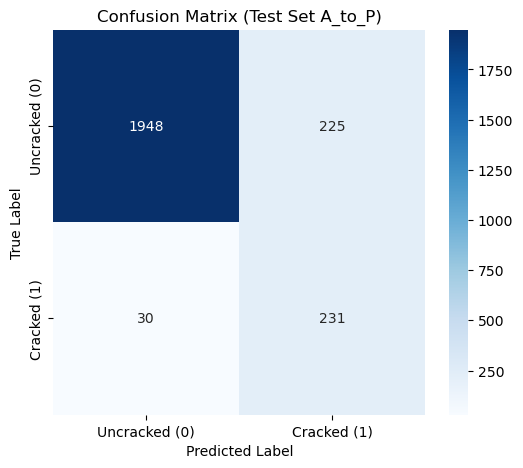


Training on set B and testing on set D
     93/Unknown 10s 77ms/step - accuracy: 0.8532 - loss: 1.0703

2024-11-20 13:28:01.457769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to best_model_transfer_B_to_D.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - accuracy: 0.8534 - loss: 1.0662 - val_accuracy: 0.9020 - val_loss: 0.2992 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
     93/Unknown 25s 196ms/step - accuracy: 0.9159 - loss: 0.3201

2024-11-20 13:28:30.118288: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:28:30.118436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 1: val_accuracy improved from 0.90202 to 0.90435, saving model to best_model_transfer_B_to_D.keras


2024-11-20 13:28:33.212552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:28:33.212676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.9157 - loss: 0.3203 - val_accuracy: 0.9044 - val_loss: 0.2569 - learning_rate: 1.0000e-05
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9047 - loss: 0.3009
Epoch 2: val_accuracy improved from 0.90435 to 0.91757, saving model to best_model_transfer_B_to_D.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9046 - loss: 0.3009 - val_accuracy: 0.9176 - val_loss: 0.2503 - learning_rate: 1.0000e-05
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9098 - loss: 0.2565
Epoch 3: val_accuracy improved from 0.91757 to 0.93235, saving model to best_model_transfer_B_to_D.keras


2024-11-20 13:28:57.451827: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-20 13:28:57.451989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:28:57.452039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9098 - loss: 0.2565 - val_accuracy: 0.9323 - val_loss: 0.1932 - learning_rate: 1.0000e-05
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9326 - loss: 0.2074
Epoch 4: val_accuracy improved from 0.93235 to 0.94168, saving model to best_model_transfer_B_to_D.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9325 - loss: 0.2076 - val_accuracy: 0.9417 - val_loss: 0.1719 - learning_rate: 1.0000e-05
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9283 - loss: 0.2468

2024-11-20 13:29:19.438903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:29:19.439037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 5: val_accuracy did not improve from 0.94168
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9284 - loss: 0.2465 - val_accuracy: 0.9401 - val_loss: 0.1884 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 4.
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Confusion Matrix (Test Set B_to_D):
[[1110   50]
 [  39   87]]

Precision: 0.6350
Recall:    0.6905

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.97      0.96      0.96      1160
     Cracked       0.64      0.69      0.66       126

    accuracy                           0.93      1286
   macro avg       0.80      0.82      0.81      1286
weighted avg       0.93      0.93      0.93      1286



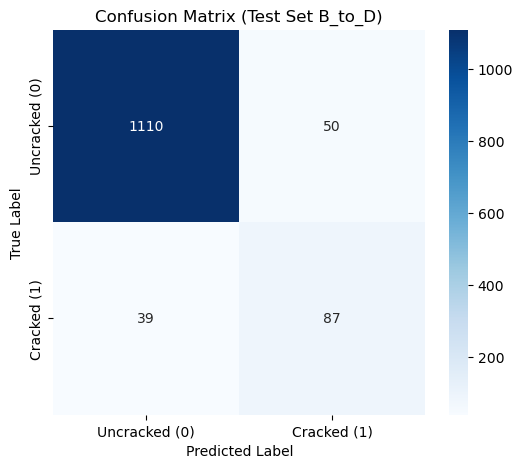


Training on set B and testing on set P
     93/Unknown 10s 59ms/step - accuracy: 0.8696 - loss: 0.4833

2024-11-20 13:29:35.626083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-20 13:29:35.626192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 1: val_accuracy improved from -inf to 0.89277, saving model to best_model_transfer_B_to_P.keras


2024-11-20 13:29:40.641504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:29:40.641657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.8698 - loss: 0.4825 - val_accuracy: 0.8928 - val_loss: 0.3146 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
     93/Unknown 19s 130ms/step - accuracy: 0.9103 - loss: 0.3218
Epoch 1: val_accuracy improved from 0.89277 to 0.89565, saving model to best_model_transfer_B_to_P.keras


2024-11-20 13:30:04.964629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:30:04.964734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.9102 - loss: 0.3217 - val_accuracy: 0.8956 - val_loss: 0.2676 - learning_rate: 1.0000e-05
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9093 - loss: 0.2587
Epoch 2: val_accuracy improved from 0.89565 to 0.90797, saving model to best_model_transfer_B_to_P.keras


2024-11-20 13:30:18.684228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:30:18.684336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9093 - loss: 0.2588 - val_accuracy: 0.9080 - val_loss: 0.2535 - learning_rate: 1.0000e-05
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9183 - loss: 0.2360
Epoch 3: val_accuracy improved from 0.90797 to 0.92358, saving model to best_model_transfer_B_to_P.keras


2024-11-20 13:30:32.577732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:30:32.577839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9183 - loss: 0.2362 - val_accuracy: 0.9236 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9271 - loss: 0.2260
Epoch 4: val_accuracy improved from 0.92358 to 0.93221, saving model to best_model_transfer_B_to_P.keras


2024-11-20 13:30:46.553753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:30:46.553869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9270 - loss: 0.2262 - val_accuracy: 0.9322 - val_loss: 0.2087 - learning_rate: 1.0000e-05
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9418 - loss: 0.1980
Epoch 5: val_accuracy did not improve from 0.93221
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9417 - loss: 0.1983 - val_accuracy: 0.9322 - val_loss: 0.2038 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 4.


2024-11-20 13:31:00.205218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:31:00.205383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Confusion Matrix (Test Set B_to_P):
[[2020  153]
 [  88  173]]

Precision: 0.5307
Recall:    0.6628

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.96      0.93      0.94      2173
     Cracked       0.53      0.66      0.59       261

    accuracy                           0.90      2434
   macro avg       0.74      0.80      0.77      2434
weighted avg       0.91      0.90      0.91      2434



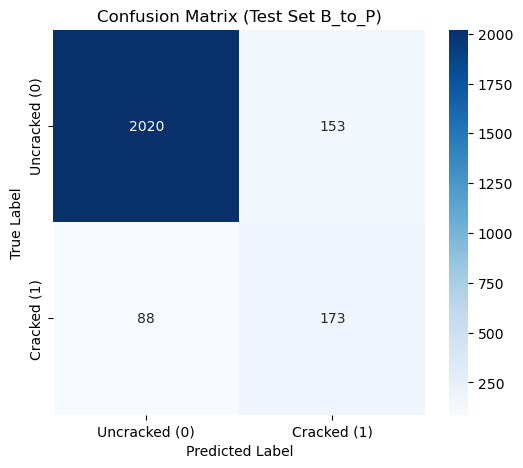


Training on set C and testing on set D
    322/Unknown 20s 53ms/step - accuracy: 0.8868 - loss: 0.4206

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to best_model_transfer_C_to_D.keras


2024-11-20 13:31:29.358012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:31:29.358114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.8869 - loss: 0.4203 - val_accuracy: 0.9020 - val_loss: 0.2582 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
    322/Unknown 45s 120ms/step - accuracy: 0.9097 - loss: 0.2268

2024-11-20 13:32:14.911839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:32:14.912200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 1: val_accuracy improved from 0.90202 to 0.95490, saving model to best_model_transfer_C_to_D.keras


2024-11-20 13:32:18.058507: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:32:18.058629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 49s 131ms/step - accuracy: 0.9098 - loss: 0.2268 - val_accuracy: 0.9549 - val_loss: 0.1457 - learning_rate: 1.0000e-05
Epoch 2/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9528 - loss: 0.1767

2024-11-20 13:32:51.016948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:32:51.017136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 2: val_accuracy improved from 0.95490 to 0.96423, saving model to best_model_transfer_C_to_D.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - accuracy: 0.9528 - loss: 0.1767 - val_accuracy: 0.9642 - val_loss: 0.1075 - learning_rate: 1.0000e-05
Epoch 3/5
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9580 - loss: 0.1529

2024-11-20 13:33:26.166693: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 3: val_accuracy did not improve from 0.96423
322/322 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9580 - loss: 0.1529 - val_accuracy: 0.9642 - val_loss: 0.1185 - learning_rate: 1.0000e-05
Epoch 4/5
  1/322 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.9375 - loss: 0.1352

2024-11-20 13:33:28.173470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:33:28.173568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9595 - loss: 0.1415

2024-11-20 13:34:00.679041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:34:00.679179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 4: val_accuracy improved from 0.96423 to 0.96501, saving model to best_model_transfer_C_to_D.keras


2024-11-20 13:34:02.686316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - accuracy: 0.9595 - loss: 0.1415 - val_accuracy: 0.9650 - val_loss: 0.0986 - learning_rate: 1.0000e-05
Epoch 5/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9634 - loss: 0.1284
Epoch 5: val_accuracy improved from 0.96501 to 0.96734, saving model to best_model_transfer_C_to_D.keras


2024-11-20 13:34:37.987946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:34:37.988072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - accuracy: 0.9634 - loss: 0.1284 - val_accuracy: 0.9673 - val_loss: 0.0858 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Confusion Matrix (Test Set C_to_D):
[[1134   26]
 [  15  111]]

Precision: 0.8102
Recall:    0.8810

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.99      0.98      0.98      1160
     Cracked       0.81      0.88      0.84       126

    accuracy                           0.97      1286
   macro avg       0.90      0.93      0.91      1286
weighted avg       0.97      0.97      0.97      1286



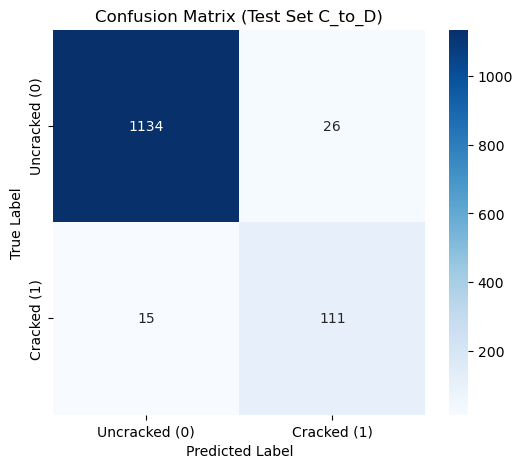


Training on set C and testing on set P
    322/Unknown 18s 50ms/step - accuracy: 0.8927 - loss: 0.4393

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.89277, saving model to best_model_transfer_C_to_P.keras


2024-11-20 13:35:06.349102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:35:06.349216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.8927 - loss: 0.4390 - val_accuracy: 0.8928 - val_loss: 0.3180 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
    322/Unknown 43s 111ms/step - accuracy: 0.9021 - loss: 0.2603
Epoch 1: val_accuracy did not improve from 0.89277
322/322 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.9021 - loss: 0.2603 - val_accuracy: 0.8829 - val_loss: 0.3030 - learning_rate: 1.0000e-05
Epoch 2/5
  1/322 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.8750 - loss: 0.1240

2024-11-20 13:35:54.359429: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9383 - loss: 0.2017
Epoch 2: val_accuracy did not improve from 0.89277
322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - accuracy: 0.9383 - loss: 0.2017 - val_accuracy: 0.8500 - val_loss: 0.3151 - learning_rate: 1.0000e-05
Epoch 3/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9476 - loss: 0.1752

2024-11-20 13:37:03.746732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:37:03.746885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 3: val_accuracy improved from 0.89277 to 0.90181, saving model to best_model_transfer_C_to_P.keras


2024-11-20 13:37:07.470038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:37:07.470182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.9476 - loss: 0.1752 - val_accuracy: 0.9018 - val_loss: 0.7825 - learning_rate: 1.0000e-05
Epoch 4/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9512 - loss: 0.1634

2024-11-20 13:37:41.076413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:37:41.076531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128



Epoch 4: val_accuracy did not improve from 0.90181
322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.9512 - loss: 0.1633 - val_accuracy: 0.8874 - val_loss: 0.3002 - learning_rate: 1.0000e-05
Epoch 5/5


2024-11-20 13:37:45.108145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:37:45.108489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9510 - loss: 0.1494
Epoch 5: val_accuracy did not improve from 0.90181

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - accuracy: 0.9511 - loss: 0.1494 - val_accuracy: 0.8689 - val_loss: 0.5689 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 3.


2024-11-20 13:38:21.733829: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14765011972775036819
2024-11-20 13:38:21.734000: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10732172815508262128


153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Confusion Matrix (Test Set C_to_P):
[[1993  180]
 [ 130  131]]

Precision: 0.4212
Recall:    0.5019

Classification Report:
              precision    recall  f1-score   support

   Uncracked       0.94      0.92      0.93      2173
     Cracked       0.42      0.50      0.46       261

    accuracy                           0.87      2434
   macro avg       0.68      0.71      0.69      2434
weighted avg       0.88      0.87      0.88      2434



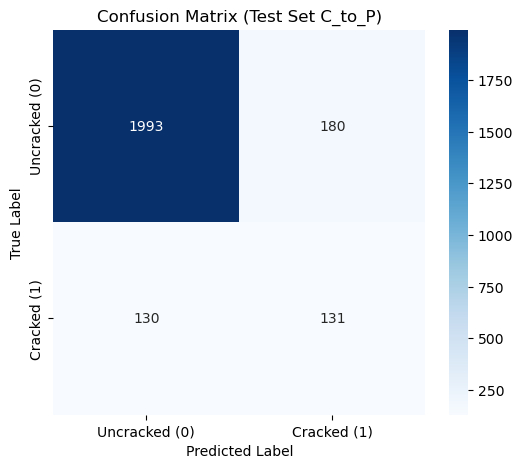

In [18]:
# Loop over each training set
for train_set in training_sets:
    train_set_name = train_set['name']
    train_gen = train_set['gen']
    train_labels = train_set['labels']

    # No need to compute class weights
    # class_weights = get_class_weights(train_labels)

    # Loop over each testing set
    for test_set in testing_sets:
        test_set_name = test_set['name']
        test_gen = test_set['gen']
        test_labels = test_set['labels']

        set_name = f'{train_set_name}_to_{test_set_name}'

        print(f'\nTraining on set {train_set_name} and testing on set {test_set_name}')

        # Call the train_and_evaluate function without class weights
        train_and_evaluate(
            train_gen=train_gen,
            test_gen=test_gen,
            train_labels=train_labels,
            test_labels=test_labels,
            set_name=set_name,
            batch_size=16,  # Adjust batch size if necessary
            alpha=1,     # Adjust alpha as needed
            gamma=0.0       # Adjust gamma as needed
        )
